## Thinking Glasses On

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

### CONCISE

In [3]:
# with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
#     frontier_sample_data = pickle.load(file)
# the_frontier_eddies = list(frontier_sample_data.keys())

# # Depths will be limited to COW depths
# d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
# for eddy in the_frontier_eddies:
#     row = []
#     for t in range(30):
#         df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
#         row.append(df.isna().idxmax() if df.isna().any() else len(df))
#     d_df.loc[eddy] = row

# # Data is interpolated 
# DEPTH_INT = 10
# methods = ['VG', 'COW', 'LNAM']
# for eddy in the_frontier_eddies:
#     for t in range(30):
#         rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
#         X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
#                                    frontier_sample_data[eddy]['T'+str(t)]['y'])
#         points = np.column_stack((X.ravel(), Y.ravel()))
#         for method in methods:
#             df = frontier_sample_data[eddy]['T'+str(t)][method]
#             # Drop Li 2022 measurement of tilt
#             if 'TD' in list(df.columns):
#                 df = df.drop(columns=['TD'])
#             # Interpolate density
#             results_df = frontier_sample_data[eddy]['T'+str(t)][method]
#             rhoc = []
#             for k in range(results_df.shape[0]):
#                 values = rho[:,:, k].ravel()
#                 xc = results_df.iloc[k]['x']
#                 yc = results_df.iloc[k]['y']
#                 target_point = np.array([[xc, yc]])
#                 rhoc.append(griddata(points, values, target_point, method='linear')[0])
#             df['rho'] = rhoc
#             # Centralise at surface center 
#             df['x'] = df['x'] - df.iloc[0]['x']
#             df['y'] = df['y'] - df.iloc[0]['y']
#             # Interpolate to equidistant z-layers
#             if df['Depth'].iloc[-1] < z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1]: # If shorter than COW don't extrapolate
#                 d = -z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1]
#             else:
#                 d = -df['Depth'].iloc[-1]
#             new_depth = np.arange(0, d + DEPTH_INT, DEPTH_INT)
#             interp_x = interp1d(-df['Depth'], df['x'], kind='linear', fill_value="extrapolate")
#             interp_y = interp1d(-df['Depth'], df['y'], kind='linear', fill_value="extrapolate")
#             interp_rho = interp1d(-df['Depth'], df['rho'], kind='linear', fill_value="extrapolate")
#             df = pd.DataFrame({
#                 "x": interp_x(new_depth),
#                 "y": interp_y(new_depth),
#                 "Depth": -new_depth,
#                 "rho": interp_rho(new_depth)
#             })
#             df['TD'] = np.hypot(df['x'], df['y'])
#             frontier_sample_data[eddy]['T'+str(t)][method] = df
#         print(t)

with open('/srv/scratch/z5297792/Sample/interp_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

### Depth Analysis

In [4]:
with open('/srv/scratch/z5297792/Sample/interp_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

medium = 'TD'
dic_best_shift = {}
methods = ['VG', 'COW', 'LNAM']
tic = time.time()
for eddy in the_frontier_eddies:
    edic_best_shift = {}
    for method in methods:
        # Find best arangement of eddy profiles
        x1 = frontier_sample_data[eddy]['T14'][method][medium]/1000 # middle day
        z1 = frontier_sample_data[eddy]['T14'][method]['Depth']
        df_best_shift = pd.DataFrame({'T14': [0, 0]}, index=['i', 'rmse'])
        xs, zs = [], []
        for t in range(30):
            x2 = frontier_sample_data[eddy]['T'+str(t)][method][medium]/1000
            z2 = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
            df = pd.DataFrame(columns=['i', 'rmse'])
            for i in np.arange(-30, 31, 1):
                x2_shifted = x2 + i
                rmse = np.sqrt(((x1 - x2_shifted) ** 2).mean())
                df.loc[len(df)] = {'i': i, 'rmse': rmse}
            i_min_rmse = df.loc[df['rmse'] == df['rmse'].min(), 'i'].iloc[0]
            min_rmse = df['rmse'].min()
            df_best_shift['T'+str(t)] = [i_min_rmse, min_rmse]
            xs.extend(x2 + i_min_rmse)
            zs.extend(z2)
        xs = np.array(xs) - np.min(xs)
        df = pd.DataFrame({'x': xs, 'z': zs})        
        edic_best_shift[method] = {'df_best_shift': df_best_shift, 'df': df}
    dic_best_shift[eddy] = edic_best_shift
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

Elapsed time: 13.4768 seconds


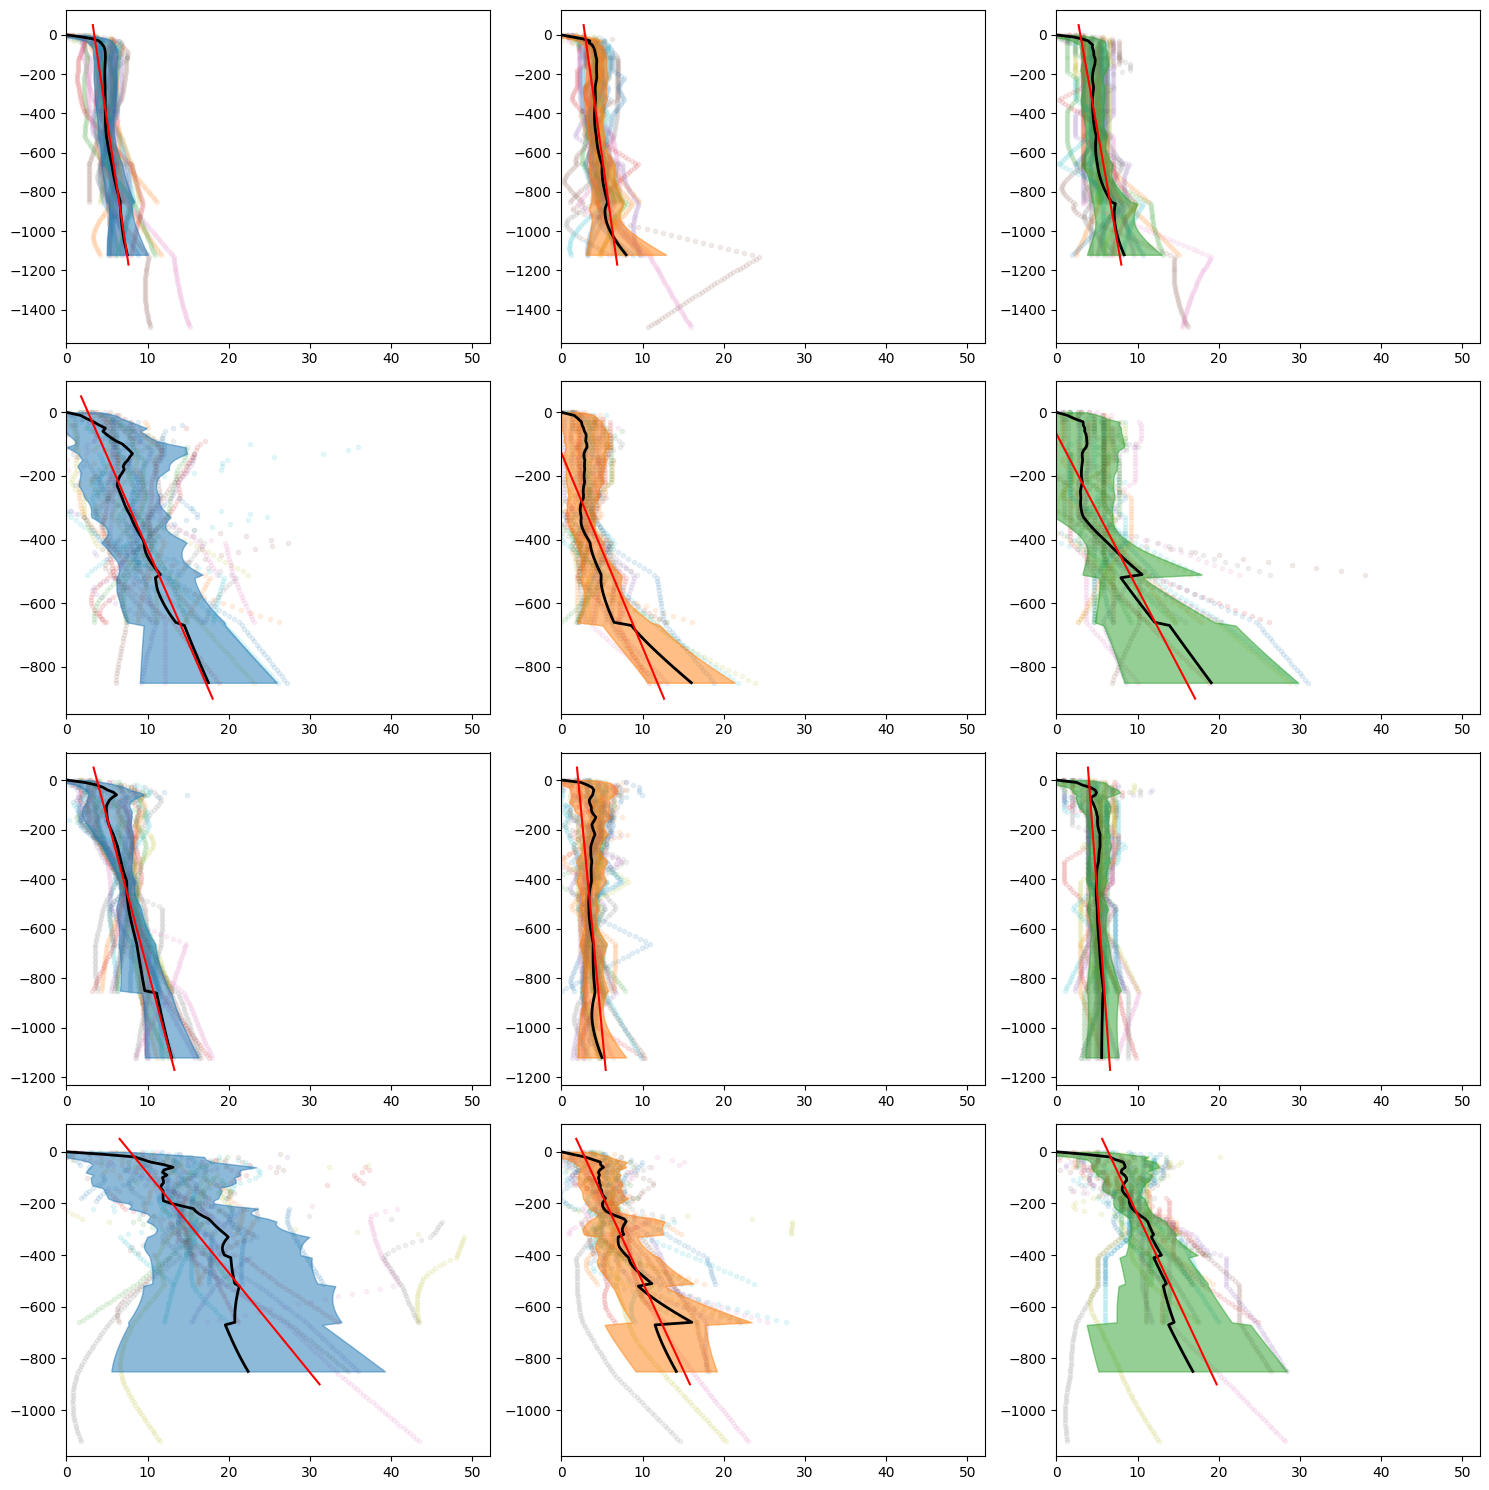

In [5]:
fig, axs  = plt.subplots(4, 3, figsize=(15, 15))
colors = plt.get_cmap('tab10')
for l, eddy in enumerate(the_frontier_eddies):
   
    for j, method in enumerate(methods):
    
        df_best_shift = dic_best_shift[eddy][method]['df_best_shift']
        xs = dic_best_shift[eddy][method]['df']['x']
        zs = dic_best_shift[eddy][method]['df']['z']
        
        DATA_THRESH = 5
        # MEAN
        df_mean = pd.DataFrame({'x': xs, 'z': zs})
        df_mean = df_mean.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
        df_mean = df_mean.groupby('z')['x'].mean().reset_index()
        pivot_x = df_mean.iloc[-1]['x']
        df_mean['x'] = df_mean['x'] - pivot_x
        xs = xs - pivot_x
        # Seperate into eddy days
        zero_indices = np.where(zs == 0)[0]
        zero_indices = np.insert(zero_indices, 0, 0)
        zero_indices = np.append(zero_indices, len(zs))
        segments = []
        for i in range(len(zero_indices) - 1):
            start = zero_indices[i]
            end = zero_indices[i + 1]
            segments.append((xs[start:end ], zs[start:end]))
        for i, (x_segment, z_segment) in enumerate(segments):
            # axs[l,j].plot(x_segment, z_segment, alpha=.5)
            axs[l,j].scatter(x_segment, z_segment, alpha=.1, marker='.')
        axs[l,j].plot(df_mean['x'], df_mean['z'], linewidth=2, color='k')
        # STD
        df_std = pd.DataFrame({'x':xs, 'z': zs})
        df_std = df_std.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
        df_std = df_std.groupby('z')['x'].std().reset_index()
        axs[l,j].fill_betweenx(df_mean['z'], 
                          df_mean['x'] - df_std['x'], 
                          df_mean['x'] + df_std['x'], 
                          color=colors(j), alpha=0.5)
        
        # Linear Regression
        x = df_mean['x']
        z = df_mean['z']
        w = 1 / df_std['x']
        
        m, b = np.polyfit(x, z, 1, w=w)
        z_min, z_max = z.min() - 50, z.max() + 50
        x_min = (z_min - b) / m
        x_max = (z_max - b) / m
        x_fit = np.array([x_min, x_max])
        z_fit = m * x_fit + b
        axs[l,j].plot(x_fit, z_fit, color='red')

xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)

for ax in axs.flat:
    ax.set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
    if medium == 'TD':
        ax.set_xlim(0, xmax)
    
plt.tight_layout()

### Density Analysis

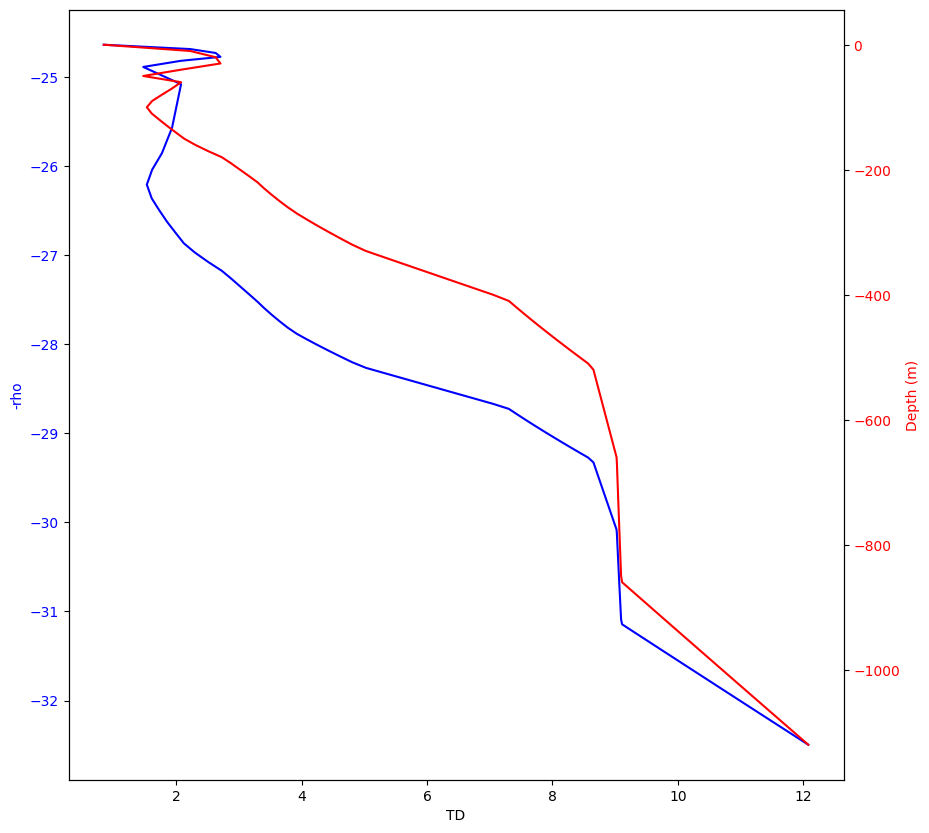

In [39]:
eddy = the_frontier_eddies[2]
t = 4
method= 'VG'

rho = frontier_sample_data[eddy]['T'+str(t)][method]['rho']
Depth = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
TD = frontier_sample_data[eddy]['T'+str(t)][method]['TD']/1000

fig, ax1 = plt.subplots(figsize=(10,10))
# First y-axis
ax1.plot(TD, -rho, 'b-', label='-rho')
ax1.set_xlabel('TD')
ax1.set_ylabel('-rho', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Second y-axis
ax2 = ax1.twinx()
ax2.plot(TD, Depth, 'r-', label='Depth')
ax2.set_ylabel('Depth (m)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Show the plot
plt.show()

In [119]:
with open('/srv/scratch/z5297792/Sample/interp_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

eddy = the_frontier_eddies[3]
t = 4
method= 'VG'

RHO_INT = 0.05

df = frontier_sample_data[eddy]['T'+str(t)][method]

new_rho_values = np.arange(np.ceil(df['rho'].min() / RHO_INT) * RHO_INT,
                           np.ceil(df['rho'].max() / RHO_INT) * RHO_INT,
                           step=RHO_INT)

interpolated_df = df.set_index('rho').reindex(new_rho_values).interpolate(method='linear').reset_index()


In [121]:
interpolated_df


,rho,x,y,Depth,TD
0,24.75,NaN,NaN,NaN,NaN
1,24.80,NaN,NaN,NaN,NaN
2,24.85,NaN,NaN,NaN,NaN
3,24.90,NaN,NaN,NaN,NaN
4,24.95,NaN,NaN,NaN,NaN
...,...,...,...,...,...
102,29.85,NaN,NaN,NaN,NaN
103,29.90,NaN,NaN,NaN,NaN
104,29.95,NaN,NaN,NaN,NaN
105,30.00,NaN,NaN,NaN,NaN


In [40]:
with open('/srv/scratch/z5297792/Sample/interp_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

medium = 'TD'
dic_best_shift_rho = {}
methods = ['VG', 'COW', 'LNAM']
tic = time.time()
for eddy in the_frontier_eddies:
    edic_best_shift_rho = {}
    for method in methods:
        # Find best arangement of eddy profiles
        x1 = frontier_sample_data[eddy]['T14'][method][medium]/1000 # middle day
        z1 = -frontier_sample_data[eddy]['T14'][method]['rho']
        df_best_shift_rho = pd.DataFrame({'T14': [0, 0]}, index=['i', 'rmse'])
        xs, zs = [], []
        for t in range(30):
            x2 = frontier_sample_data[eddy]['T'+str(t)][method][medium]/1000
            z2 = -frontier_sample_data[eddy]['T'+str(t)][method]['rho']
            df = pd.DataFrame(columns=['i', 'rmse'])
            for i in np.arange(-30, 31, 1):
                x2_shifted = x2 + i
                rmse = np.sqrt(((x1 - x2_shifted) ** 2).mean())
                df.loc[len(df)] = {'i': i, 'rmse': rmse}
            i_min_rmse = df.loc[df['rmse'] == df['rmse'].min(), 'i'].iloc[0]
            min_rmse = df['rmse'].min()
            df_best_shift_rho['T'+str(t)] = [i_min_rmse, min_rmse]
            xs.extend(x2 + i_min_rmse)
            zs.extend(z2)
        xs = np.array(xs) - np.min(xs)
        df = pd.DataFrame({'x': xs, 'z': zs})        
        edic_best_shift_rho[method] = {'df_best_shift': df_best_shift_rho, 'df': df}
    dic_best_shift_rho[eddy] = edic_best_shift_rho
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

Elapsed time: 13.6405 seconds


In [44]:
dic_best_shift_rho[eddy][method]['df_best_shift']


,T14,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
i,0.0,7.000000,7.000000,1.000000,10.000000,14.000000,9.000000,-3.000000,14.000000,14.000000,...,11.000000,14.000000,11.000000,8.000000,-2.000000,12.00000,-2.000000,11.00000,15.000000,15.000000
rmse,0.0,2.437909,2.940726,3.570435,3.844431,3.572012,3.450776,3.036924,4.622679,4.222404,...,3.327063,5.118405,3.879608,3.363596,3.360231,3.58567,5.417625,5.89862,5.683231,5.516002


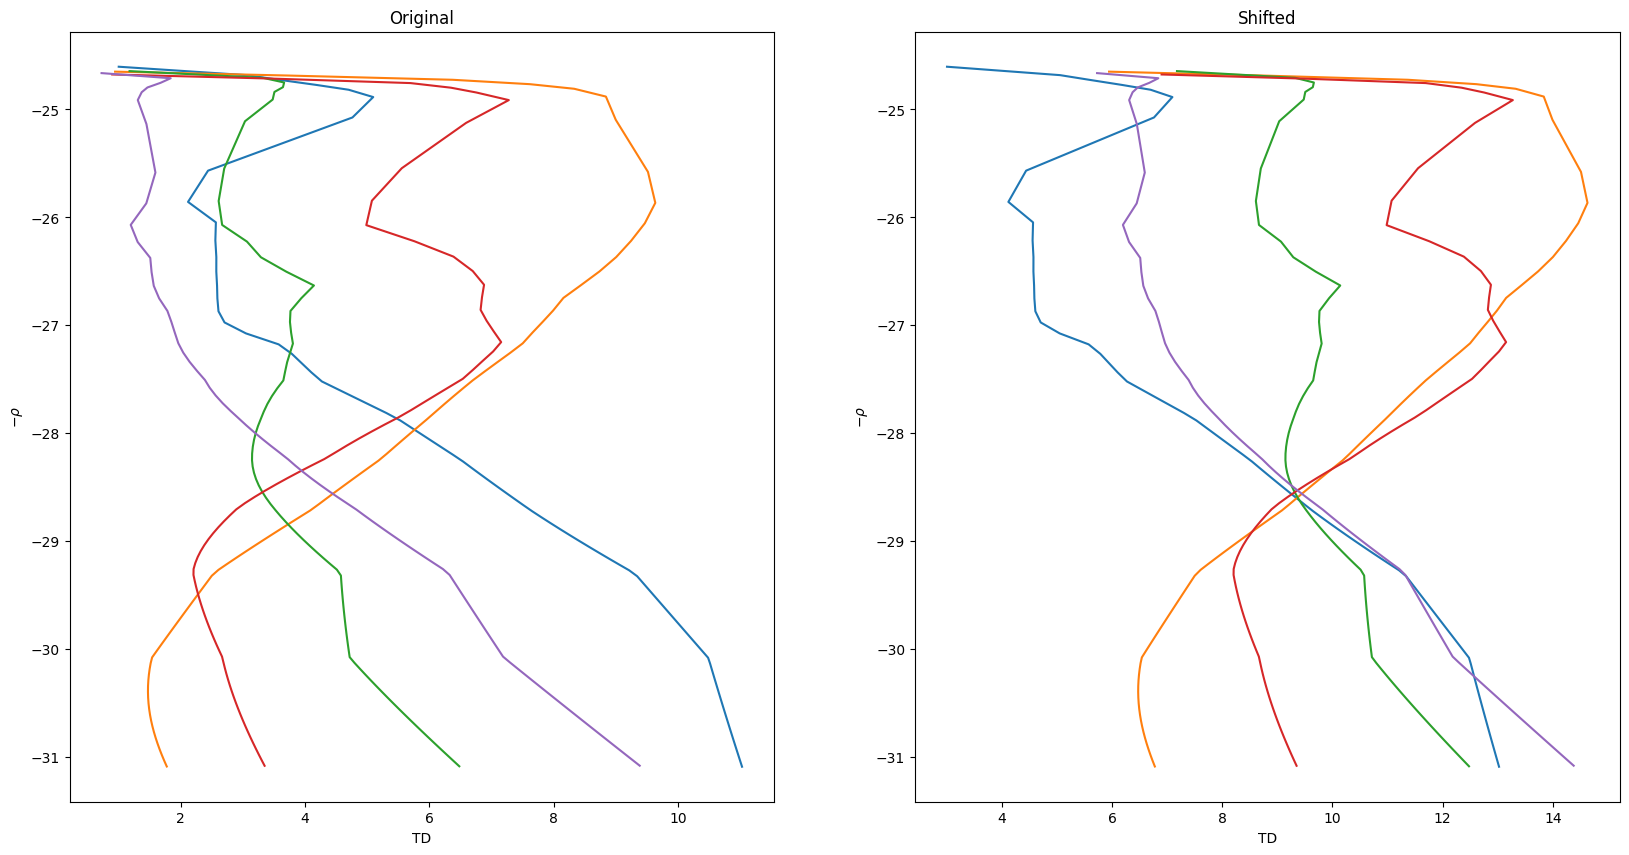

In [77]:
eddy = the_frontier_eddies[2]

method= 'VG'

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for t in range(5, 10):

    rho = frontier_sample_data[eddy]['T'+str(t)][method]['rho']
    Depth = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
    TD = frontier_sample_data[eddy]['T'+str(t)][method]['TD']/1000
    i_shift = dic_best_shift_rho[eddy][method]['df_best_shift'].loc['i']['T'+str(t)]
    
    # First y-axis
    axs[0].plot(TD, -rho)
    axs[0].set_xlabel('TD')
    axs[0].set_ylabel(r'$-\rho$')
    axs[0].set_title('Original')
    # Second y-axis
    axs[1].plot(TD + i_shift, -rho)
    axs[1].set_xlabel('TD')
    axs[1].set_ylabel(r'$-\rho$')
    axs[1].set_title('Shifted')

plt.show()

In [84]:
df.loc[:, 'z'].sort_values().index

Index([2660, 2510, 2659, 2509, 2658, 2508, 2657, 2507, 2656, 2506,
       ...
       2511, 1145, 2661, 2361, 1059, 1258, 2248,  973, 2887, 1371],
      dtype='int64', length=3113)

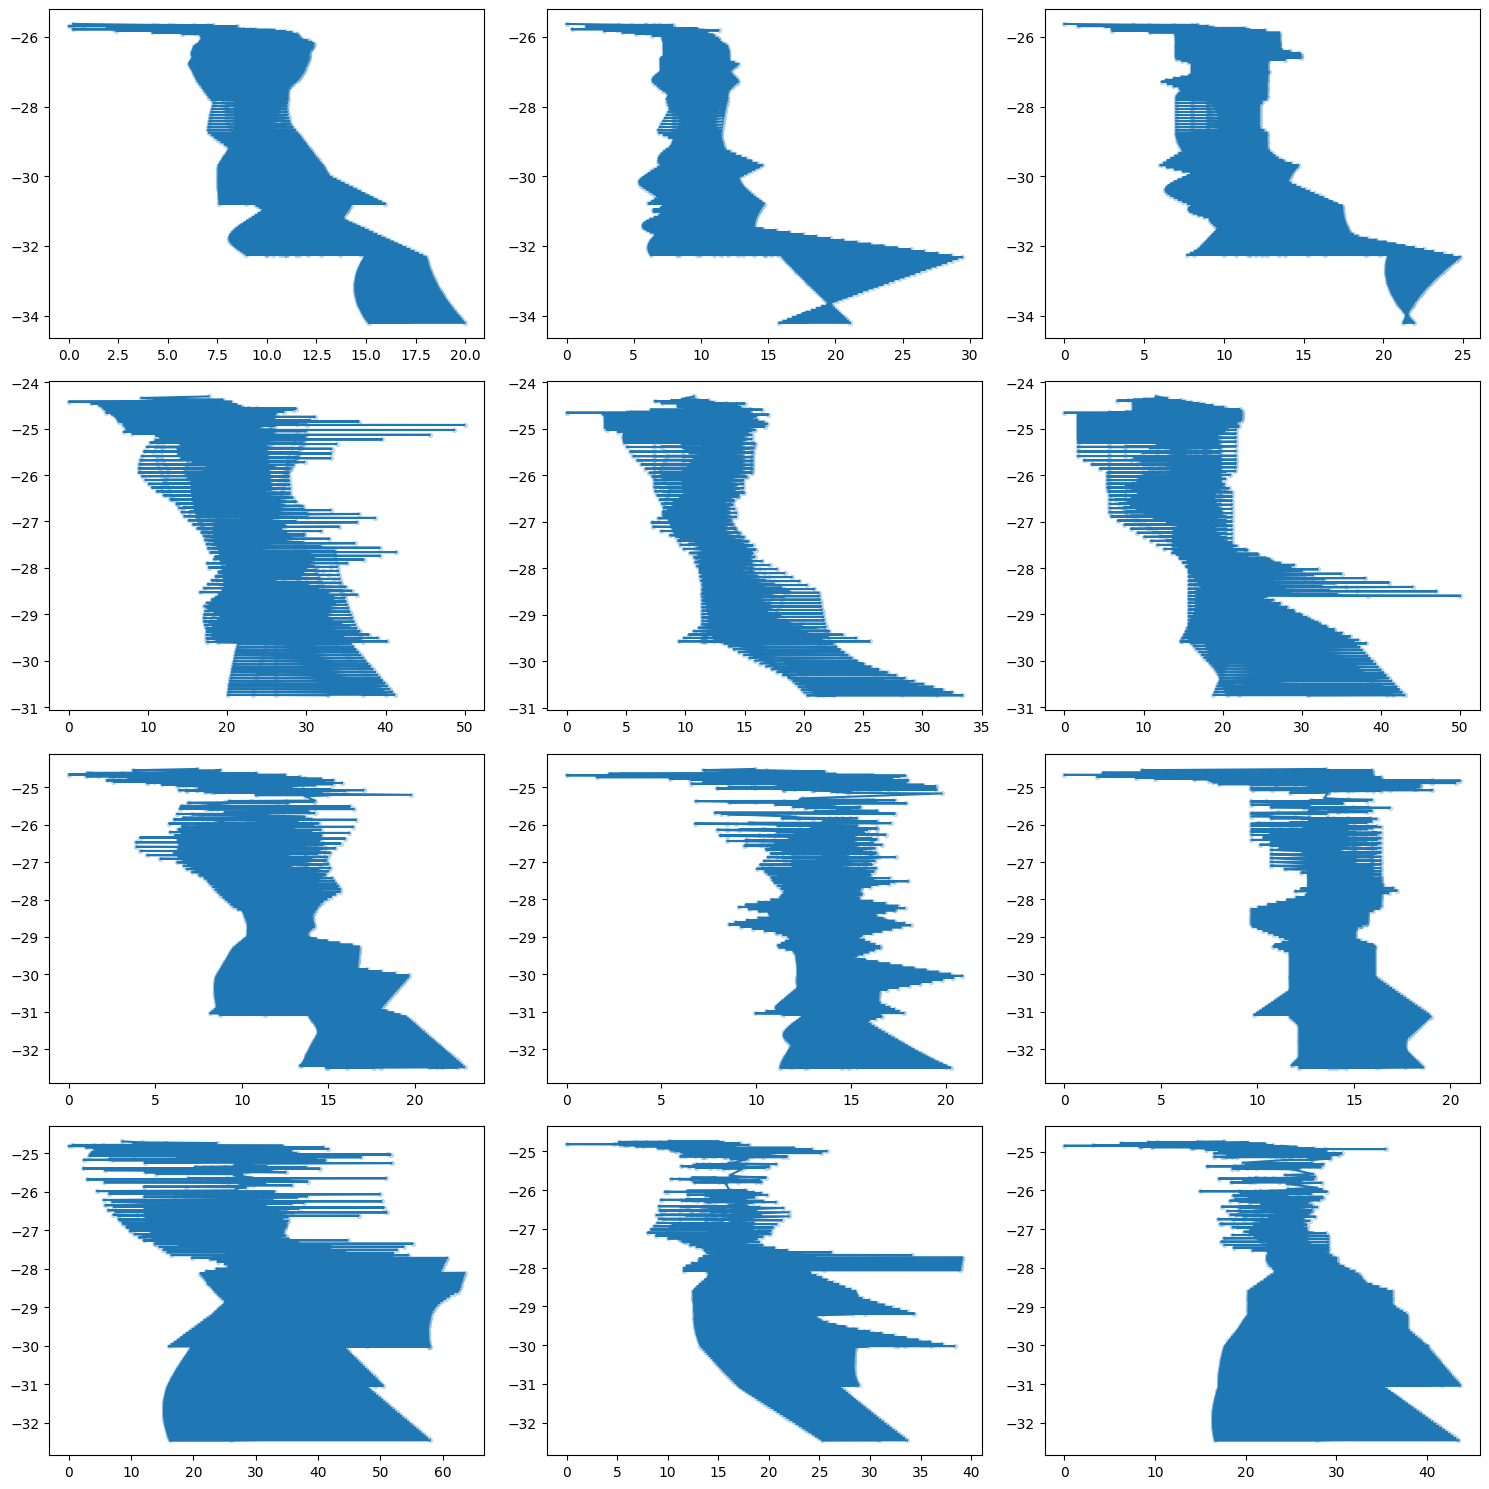

In [88]:
fig, axs  = plt.subplots(4, 3, figsize=(15, 15))
colors = plt.get_cmap('tab10')
for l, eddy in enumerate(the_frontier_eddies):
   
    for j, method in enumerate(methods):
    
        df_best_shift_rho = dic_best_shift_rho[eddy][method]['df_best_shift']
        xs = dic_best_shift_rho[eddy][method]['df']['x']
        zs = dic_best_shift_rho[eddy][method]['df']['z']

        axs[l,j].scatter(xs, zs, alpha=.2, marker ='.')

        df = pd.DataFrame({'x': xs, 'z': zs})
        df = df.sort_values(by='z')

        DATA_THRESH = 5
        # MEAN
        axs[l,j].plot(df['x'], df['z'])
        # Seperate into eddy days
        # STD
        # df_std = pd.DataFrame({'x':xs, 'z': zs})
        # df_std = df_std.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
        # df_std = df_std.groupby('z')['x'].std().reset_index()
        # axs[l,j].fill_betweenx(df_mean['z'], 
        #                   df_mean['x'] - df_std['x'], 
        #                   df_mean['x'] + df_std['x'], 
        #                   color=colors(j), alpha=0.5)
        
        # # Linear Regression
        # x = df_mean['x']
        # z = df_mean['z']
        # w = 1 / df_std['x']
        
        # m, b = np.polyfit(x, z, 1, w=w)
        # z_min, z_max = z.min() - 50, z.max() + 50
        # x_min = (z_min - b) / m
        # x_max = (z_max - b) / m
        # x_fit = np.array([x_min, x_max])
        # z_fit = m * x_fit + b
        # axs[l,j].plot(x_fit, z_fit, color='red')

# xmax = 0
# xmin = 0
# for ax in axs.flat:
#     xmax = max(ax.get_xlim()[1], xmax)
#     xmin = min(ax.get_xlim()[0], xmin)

# for ax in axs.flat:
#     ax.set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
#     if medium == 'TD':
#         ax.set_xlim(0, xmax)
    
plt.tight_layout()

In [ ]:
df_mean